<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.dates as mdates
import pandas as pd
import scipy as sp
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy import stats
from datetime import timedelta, datetime
import sympy as smp
from IPython.display import display, Math
smp.init_printing()
%matplotlib inline

In [3]:
date = 'jan_26_2019'
path = 'datafiles/'+date

In [4]:
ratio_mean_guess = 0.78
ratio_std_guess = 0.02

# Open DataFrames

In [5]:
upper_int = 100000
lower_int = 0

## Pulse Data

Open up all runs.

In [6]:
dfs = []
for filename in os.listdir(path):
    if filename.endswith(".csv"):
        df = pd.read_csv(path+'/'+filename, sep=',', index_col=0).astype(float)
        df['ratio']=df['Integral 1200']/df['Integral 7400']
        df.index = pd.to_datetime(df.index,unit='s')-timedelta(hours=7)
        
        df = df[(df['ratio']<1) & (df['ratio']>0)] #should not have to do this
        df = df[(df['Integral 7400']<upper_int) & (df['Integral 7400']>lower_int)] #should not have to do this
        dfs.append(df)

dfs = sorted(dfs,key=lambda x:x.index[0]) #sort by initial time

Get beginning and end of each run. Need to subtract 1 hour because computer did not account for the time change.

In [7]:
begins = sorted([df.index.values[0]-np.timedelta64(1,'h') for df in dfs])
ends = sorted([df.index.values[-1]-np.timedelta64(1,'h') for df in dfs])

## Temperature Data

In [8]:
temps = []
for filename in os.listdir(path):
    if filename.endswith(".txt"):
        temp = pd.read_csv(path+'/'+filename, skiprows=7, sep='\t')
        temp['Time'] = pd.to_datetime(temp['DATE']+'-'+temp['TIME'])
        temp.index = temp['Time']
        temp = temp[['TEMPERATURE', 'RELATIVE-HUMIDITY', 'DEW-POINT']]
        temps.append(temp)
temps = sorted(temps,key=lambda x:x.index[0]) #sort by initial time

# Preliminary Plots

## Energy Ratios Sample Plot

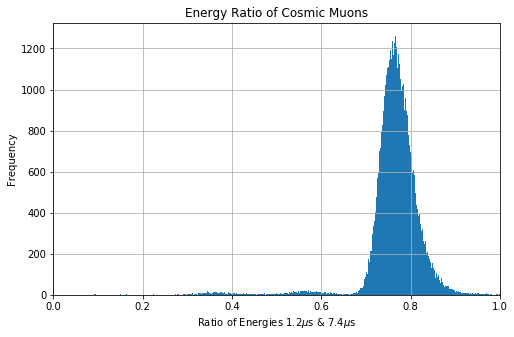

In [9]:
fig, ax = plt.subplots(figsize=(8,5))

dfs[0]['ratio'].hist(bins=500, ax=ax)

ax.set_xlim(0,1)
ax.set_xlabel('Ratio of Energies 1.2$\mu$s & 7.4$\mu$s')
ax.set_ylabel('Frequency')
ax.set_title('Energy Ratio of Cosmic Muons')
plt.show()

## Energy Deposited Sample Plot

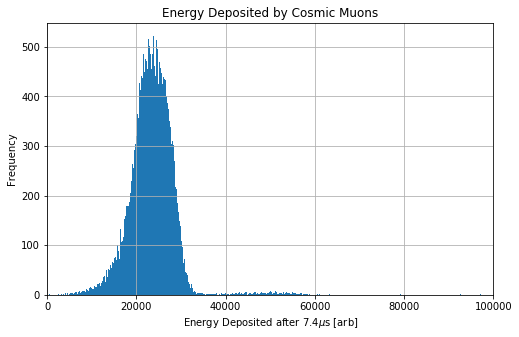

In [10]:
fig, ax = plt.subplots(figsize=(8,5))

dfs[0]['Integral 7400'].hist(bins=1000, ax=ax)
ax.set_xlim(0,100000)
ax.set_xlabel('Energy Deposited after 7.4$\mu$s [arb]')
ax.set_ylabel('Frequency')
ax.set_title('Energy Deposited by Cosmic Muons')

plt.show()

## 2D Histogram Sample Plot

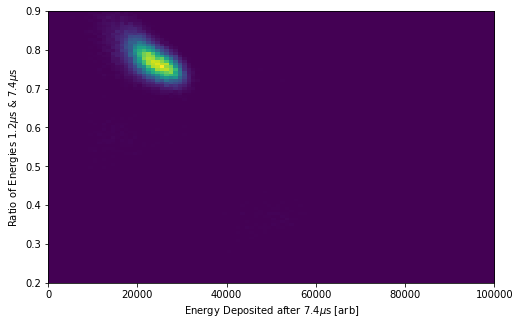

In [11]:
fig, ax = plt.subplots(figsize=(8,5))

ax.hist2d(dfs[0]['Integral 7400'].values, dfs[0]['ratio'].values,
          range=np.array([(0, 100000), (0.2, 0.9)]), bins=100)

ax.set_xlabel('Energy Deposited after 7.4$\mu$s [arb]')
ax.set_ylabel('Ratio of Energies 1.2$\mu$s & 7.4$\mu$s')

plt.show()

# Fitting Methods to Find the Mode

In [12]:
df = dfs[0]

Define the normal curve:

In [13]:
def norm(x, u, sig, amp):
    return amp*np.exp(-((x-u)**2)/(2*sig**2))

Fit the histogram data between 0.75 and 0.8.

In [14]:
mask = (df['ratio']>0.74) & (df['ratio']<0.78)

h, x , _ = plt.hist(df['ratio'][mask], bins=25); plt.close()
x = x[:-1]

p0  = (ratio_mean_guess, ratio_std_guess, np.max(h))
popt, pcov = curve_fit(norm, x, h, p0=p0)
perr = np.sqrt(np.diag(pcov))

Initial Plot.

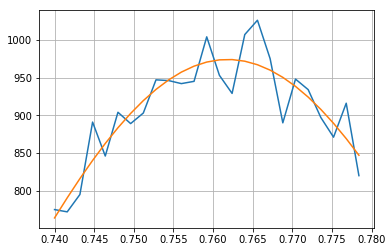

In [15]:
fig, ax = plt.subplots()

ax.plot(x,h)
ax.plot(x,norm(x, popt[0], popt[1], popt[2]), label='Fit')

#ax.set_ylim(0, 400)
ax.grid()

Do plotting:

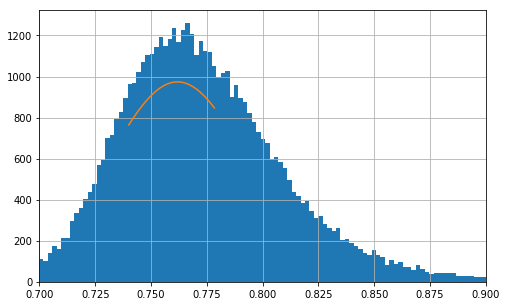

In [16]:
fig, ax = plt.subplots(figsize=(8,5))

y= df['ratio'].hist(bins=500, ax=ax)
ax.plot(x,norm(x, popt[0], popt[1], popt[2]), label='Fit')

ax.set_xlim(0.7,0.9)
plt.show()

## Automation

Now we fit the curve for all histograms. Rather than showing the fitted curve with the histogram, we show the mean and standard deviation as bars.

In [17]:
def mode_ratio(df):
    mask = (df['ratio']>0.74) & (df['ratio']<0.78)

    h, x , _ = plt.hist(df['ratio'][mask], bins=25); plt.close()
    x = x[:-1]

    p0  = (ratio_mean_guess, ratio_std_guess, np.max(h))
    popt, pcov = curve_fit(norm, x, h, p0=p0)
    perr = np.sqrt(np.diag(pcov))
    
    return popt, perr

def create_plots(dfs, params, run_num, ax):
    a = ax.ravel()
    for (i,df) in enumerate(dfs):
        
        # Plot histogram
        df['ratio'].hist(bins=500, ax=a[i])
        
        # Mean and STD
        mean = params[i][0][0]
        std = params [i][0][1]
        
        a[i].axvline(mean, c='k', linestyle='--') #mean
        (lwr,upr) = (mean-std, mean+std)
        a[i].axvspan(lwr, upr, alpha=0.1, color='red', label='Standard Error') ##std
        
        #Label Options
        a[i].set_xlim(0.7, 0.9)
        a[i].set_title(date+'_run'+str(run_num)+'_data'+str(i))
    plt.savefig('plots/run_peaks/'+date+'run'+str(run_num)+'.png')
        
    return None
    

Make plots of each run:

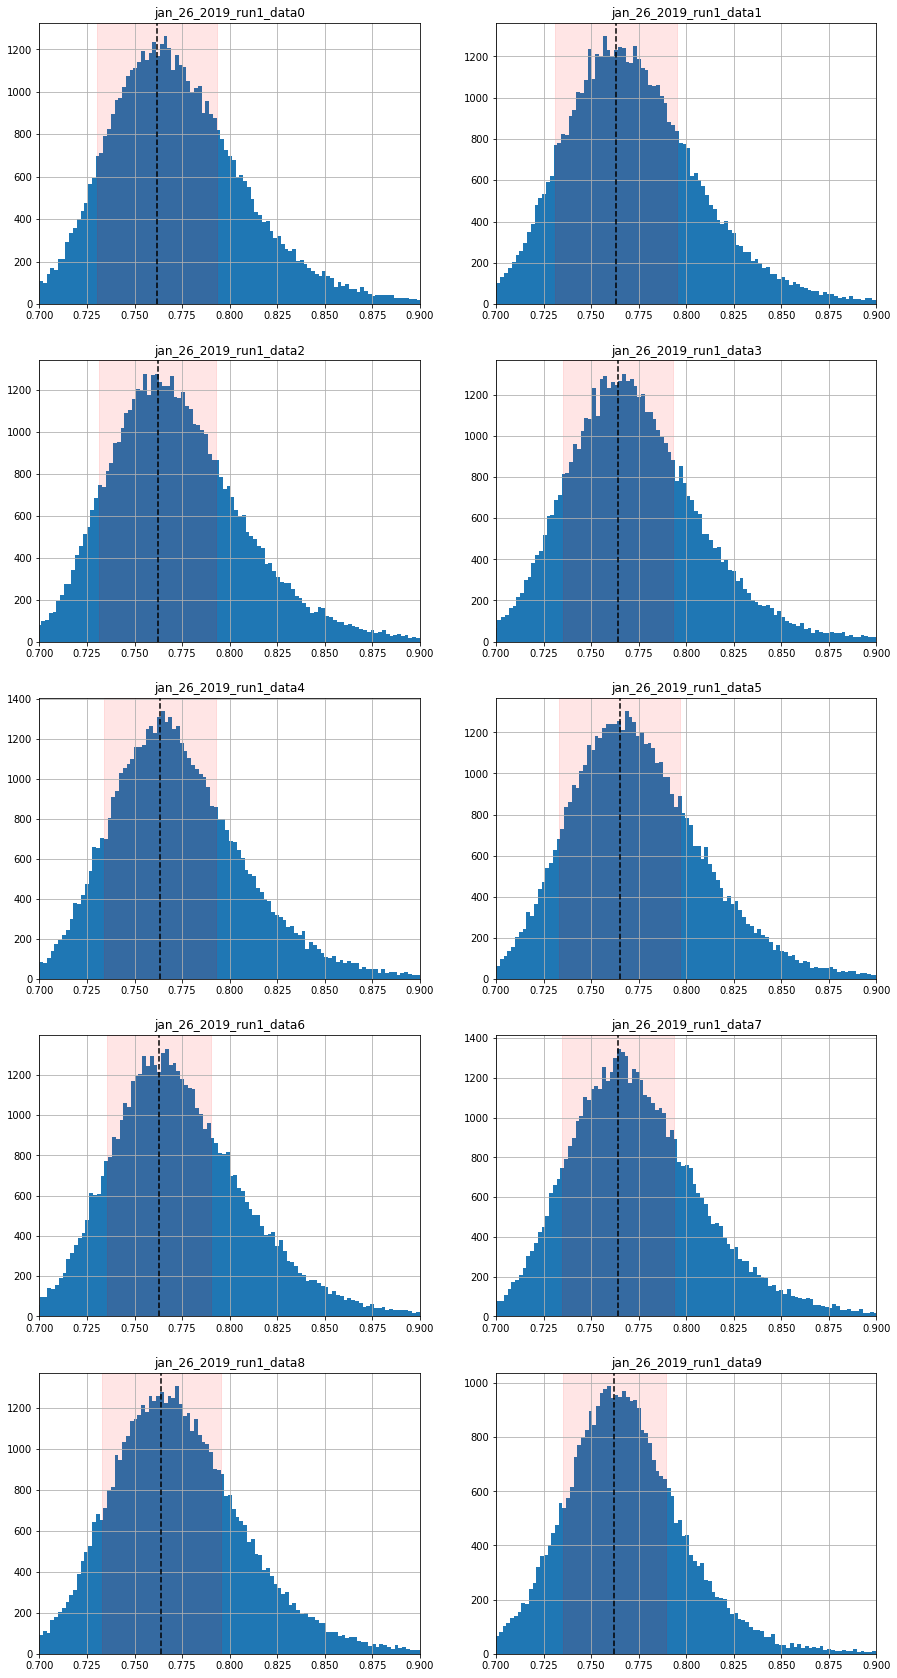

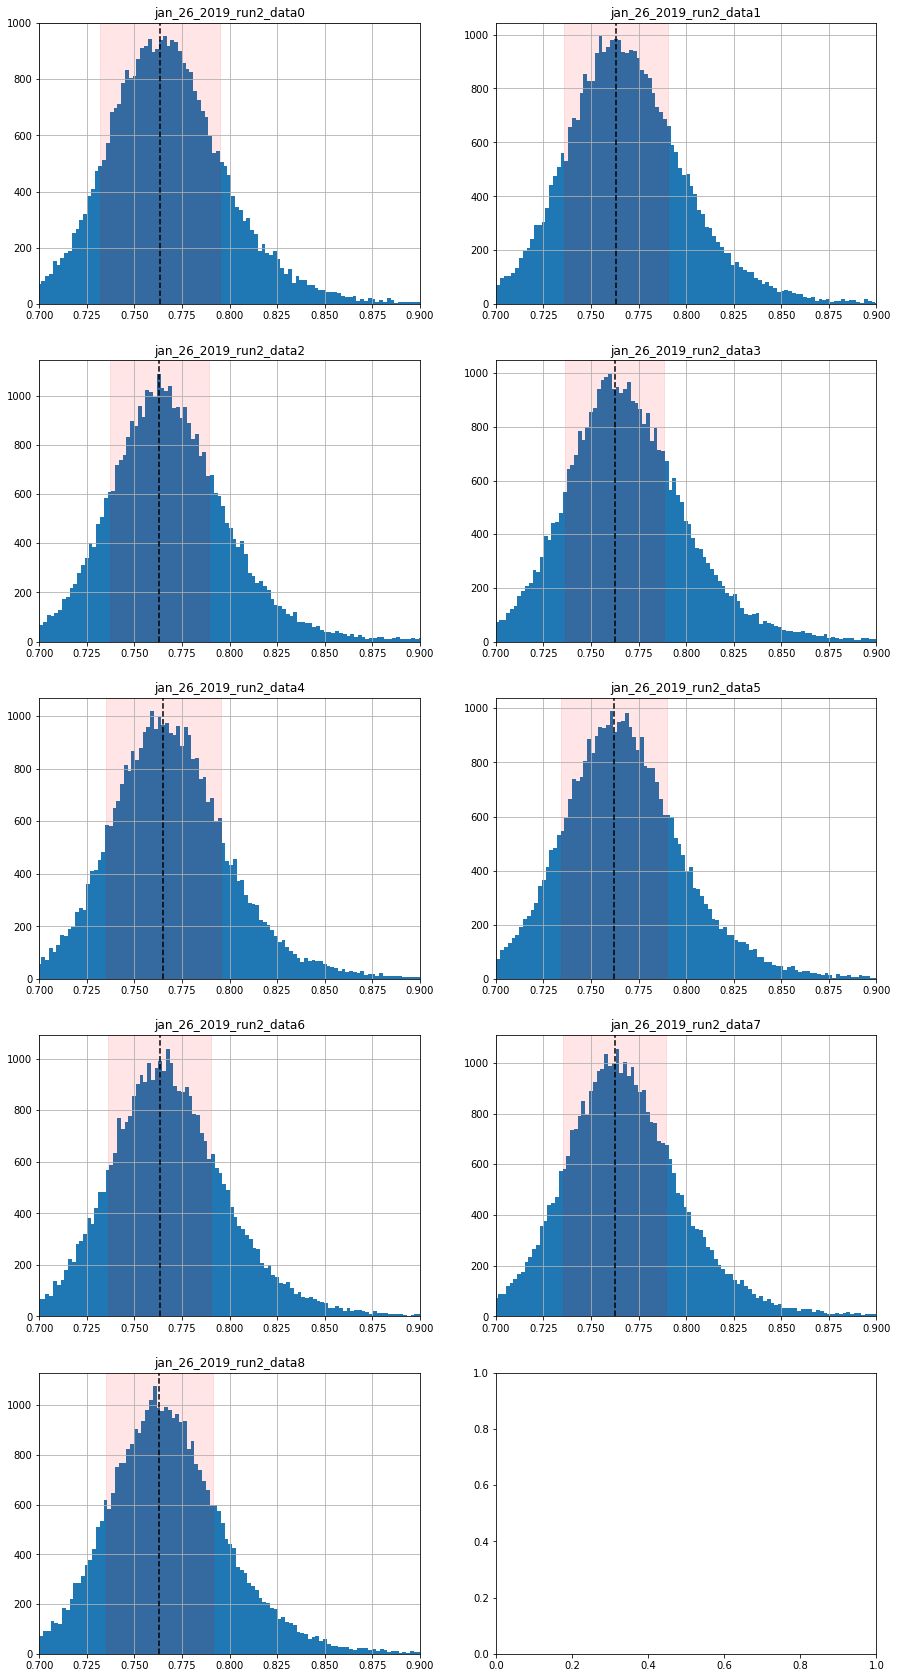

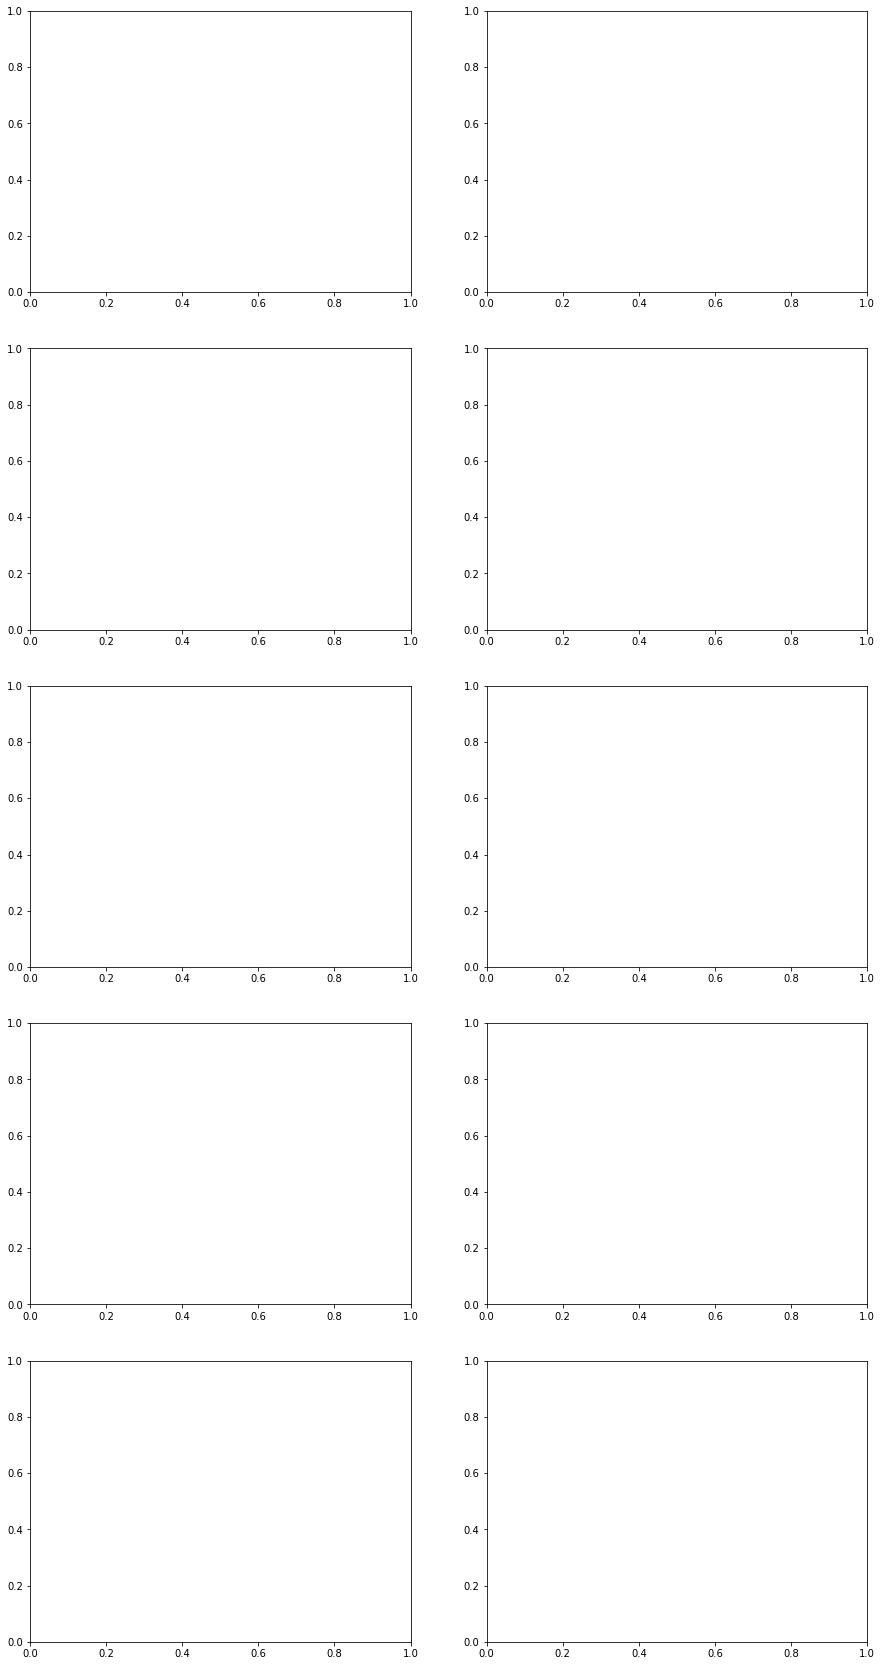

In [18]:
params = [mode_ratio(df) for df in dfs]

dfs_run1, params_run1 = dfs[0:10], params[0:10]
dfs_run2, params_run2 = dfs[10:20], params[10:20]
dfs_run3, params_run3 = dfs[20:30], params[20:30]

fig, ax = plt.subplots(5, 2, figsize=(15,30))
create_plots(dfs_run1, params_run1, 1, ax)
plt.show()

fig, ax = plt.subplots(5, 2, figsize=(15,30))
create_plots(dfs_run2, params_run2, 2, ax)
plt.show()

fig, ax = plt.subplots(5, 2, figsize=(15,30))
create_plots(dfs_run3, params_run3, 3, ax)
plt.show()


# 2D Histogram Stuff:

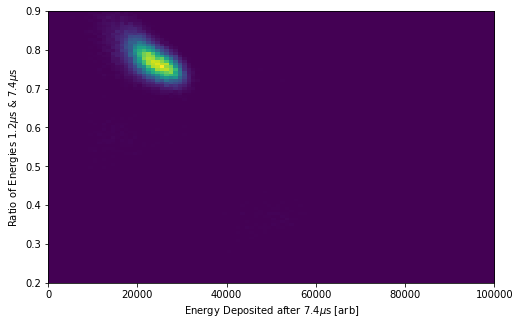

In [19]:
fig, ax = plt.subplots(figsize=(8,5))

ax.hist2d(df['Integral 7400'].values, df['ratio'].values,
          range=np.array([(0, 100000), (0.2, 0.9)]), bins=100)

ax.set_xlabel('Energy Deposited after 7.4$\mu$s [arb]')
ax.set_ylabel('Ratio of Energies 1.2$\mu$s & 7.4$\mu$s')

plt.show()

# Temperature Stuff

## Create plots of Temperature During Data Runs and Save

The red regions signify times when data is being collected.

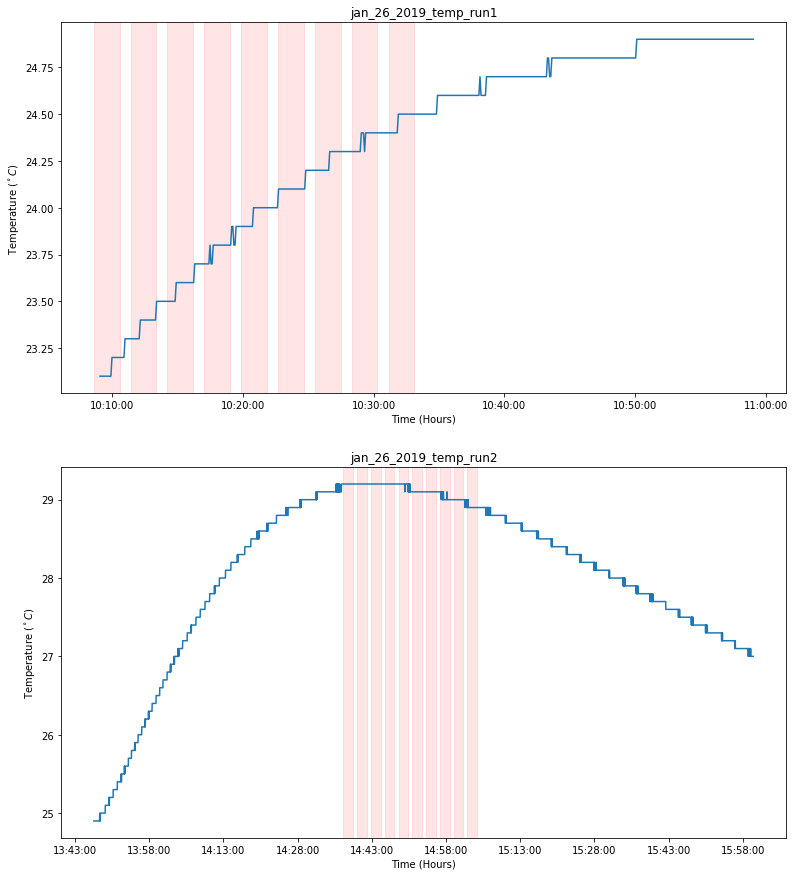

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(13,15))

ax[0].plot(temps[0]['TEMPERATURE'])
ax[1].plot(temps[1]['TEMPERATURE'])
#ax[2].plot(temps[2]['TEMPERATURE'])

[ax[0].axvspan(begin, end, alpha=0.1, color='red') for begin,end in zip(begins[0:9], ends[0:9])] 
[ax[1].axvspan(begin, end, alpha=0.1, color='red') for begin,end in zip(begins[9:19], ends[9:19])] 
#[ax[2].axvspan(begin, end, alpha=0.1, color='red') for begin,end in zip(begins[20:30], ends[20:30])] 

xfmt = mdates.DateFormatter('%H:%M:%S')
[a.xaxis.set_major_formatter(xfmt) for a in ax]

for (i, a) in enumerate(ax):
    a.set_title(date+'_temp_run'+str(i+1))
[a.set_ylabel('Temperature ($^\circ C$)') for a in ax]
[a.set_xlabel('Time (Hours)') for a in ax]

plt.savefig('plots/temp_runs/'+date+'.png')
plt.show()

## Find Mean and STD Temperature During each of the Red Bars

Now we take the mean and standard deviation of the temperature values per data run. These will be used as data points in the final plot "mean energy ratio as a function of temperature."

In [21]:
all_temps = pd.concat(temps)

def compute_datapoint(df):
    begin = df.index.values[0]-np.timedelta64(1,'h')
    end = df.index.values[-1]-np.timedelta64(1,'h')
    
    temp_mean = all_temps[(all_temps.index>begin)&(all_temps.index<end)]['TEMPERATURE'].mean()
    temp_err = all_temps[(all_temps.index>begin)&(all_temps.index<end)]['TEMPERATURE'].std()
    
    ratio = mode_ratio(df)[0][0]
    ratio_err = mode_ratio(df)[1][0]
    
    return [[temp_mean, ratio], [temp_err, ratio_err]]

Get the data and the errors.

In [22]:
data = [compute_datapoint(df) for df in dfs]

tmps = np.array([data[i][0][0] for i in range(len(data))])
ratios = np.array([data[i][0][1] for i in range(len(data))])
tmps_err =np.array([data[i][1][0] for i in range(len(data))])
ratios_err =np.array([data[i][1][1] for i in range(len(data))])

Do a linear fit on the data, with errors at 95% confidence

In [24]:
def func(x, a, b):
    return a+b*x

[a, b], pcov = curve_fit(func, tmps, ratios)
perr = np.sqrt(np.diag(pcov))
[del_a, del_b] = sp.stats.t.ppf(1-0.05/2, len(tmps)-2)*perr

lin_fit = a+b*tmps
lin_fit_upr = (a-del_a)+(b+del_b)*tmps
lin_fit_lwr = (a+del_a)+(b-del_b)*tmps

Sample final plot...

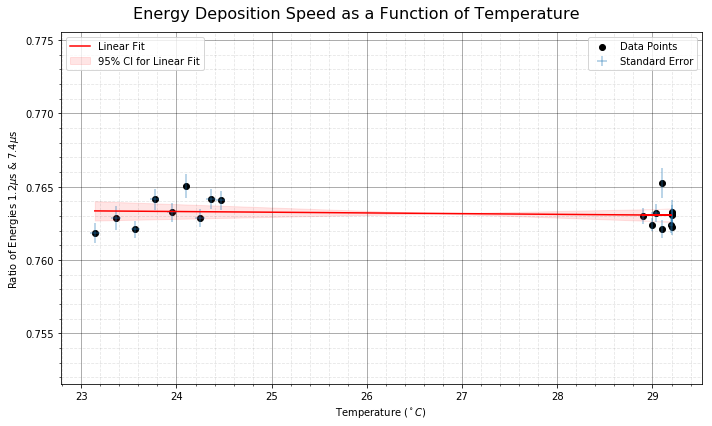

In [25]:
fig, ax = plt.subplots(figsize=(10,6))

#Data
plt_d = ax.scatter(tmps, ratios, color='k', label='Data Points')
plt_de = ax.errorbar(tmps, ratios, xerr=tmps_err, yerr=ratios_err, linestyle='', alpha=0.4, label='Standard Error')

#Fitting
plt_lf, = ax.plot(tmps, lin_fit, color='r', label='Linear Fit')
plt_lfe = ax.fill_between(tmps, lin_fit_lwr, lin_fit_upr, color='r', alpha=0.1, label='95% CI for Linear Fit')

#Other
#ax.set_ylim(0.792, 0.805)

ax.set_xlabel('Temperature ($^\circ C$)')
ax.set_ylabel('Ratio of Energies 1.2$\mu$s & 7.4$\mu$s')
fig.suptitle('Energy Deposition Speed as a Function of Temperature', fontsize=16)

plt.minorticks_on()
ax.grid(b=True, which='major', color='k', linestyle='-', alpha=0.4)
ax.grid(b=True, which='minor', color='k', linestyle='--', alpha=0.1)

#Legends
first_legend = plt.legend(handles=[plt_d, plt_de], loc=1)
second_legend = plt.legend(handles=[plt_lf, plt_lfe], loc=2)
ax = plt.gca().add_artist(first_legend)

fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.savefig('plots/sample_final_plot.png', dpi=600)
plt.show()
